# 對 PTT 特斯拉 公司進行情緒分析

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- matplotlib: 繪圖工具。
- wordcloud: 繪製文字雲工具。
- jieba: 中文斷詞工具。

## 本機使用套間
請先於環境中使用 pip install

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.font_manager as font_manager
from wordcloud import WordCloud 
import jieba

## colab 使用套件

In [2]:
# Path to the custom font
font_path = 'font/TraditionalChinese.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: Noto Sans TC


## 2. 資料前處理
如 week3 所示  
使用「吃到飽」作為關鍵字，從工作流程系統中將 ptt 資料下載下來 .from助教

### 2.1 基本資料介紹
- 資料來源: 工作流程蒐集 PTT 特斯拉 Stock 2023/1/1~2024/4/30 所有文章

In [3]:
df = pd.read_csv("data/ppt_tesla.csv")
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date 
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,xross,car,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""maniaque"", ""...",99.36.164.58,2023-01-02 01:04:34,ptt
1,2,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,jpopo0543,car,各位前輩好\r\n 想買中古特斯拉\r\n里程約5萬上下的\r\n\r\n擔心電池久了會掉電...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""r7698"", ""cmt...",114.46.142.179,2023-01-02 01:04:40,ptt
2,3,https://www.ptt.cc/bbs/car/M.1672634853.A.527....,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,2023-01-02,weiflower520,car,原文連結：\r\nhttps://star.setn.com/news/1232578?ut...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""tyrande"", ""c...",27.247.164.57,2023-01-03 01:04:36,ptt
3,4,https://www.ptt.cc/bbs/car/M.1672653666.A.3F2....,[討論]是不是真的有些四輪覺得自己是大爺？,2023-01-02,torrest,car,如題 本身開特斯拉\r\n\r\n最近出門覺得找車位很煩都騎家裡超舊機車\r\n\r\n基本...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""kutkin"", ""cm...",27.242.163.97,2023-01-03 01:04:36,ptt
4,5,https://www.ptt.cc/bbs/car/M.1672658487.A.A66....,[新聞]2022美國汽車召回排名揭曉第一名超過8,2023-01-02,SakuraHana,car,原文連結：\r\nhttps://auto.ltn.com.tw/news/21866/3\...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""luke2007"", ""...",220.129.145.135,2023-01-03 01:04:36,ptt


### 2.2資料清理

In [4]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,八卦是官網特斯拉二手車\r\r比很多第三方平台都便宜\r\r等等黨會勝利嗎?\r
1,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\r\n 想買中古特斯拉\r\n里程約5萬上下的\r\n\r\n擔心電池久了會掉電...,各位前輩好\r 想買中古特斯拉\r里程約5萬上下的\r\r擔心電池久了會掉電\r越充越少電 ...
2,https://www.ptt.cc/bbs/car/M.1672634853.A.527....,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,2023-01-02,原文連結：\r\nhttps://star.setn.com/news/1232578?ut...,原文連結：\r\rinpage&fbclid=IwAR0oux4XHXAJRTNgQmBWT...
3,https://www.ptt.cc/bbs/car/M.1672653666.A.3F2....,[討論]是不是真的有些四輪覺得自己是大爺？,2023-01-02,如題 本身開特斯拉\r\n\r\n最近出門覺得找車位很煩都騎家裡超舊機車\r\n\r\n基本...,如題 本身開特斯拉\r\r最近出門覺得找車位很煩都騎家裡超舊機車\r\r基本上在路上有機車道...
4,https://www.ptt.cc/bbs/car/M.1672658487.A.A66....,[新聞]2022美國汽車召回排名揭曉第一名超過8,2023-01-02,原文連結：\r\nhttps://auto.ltn.com.tw/news/21866/3\...,原文連結：\r\r原文內容：\r2022 美國汽車召回排名揭曉 第一名超過 800 萬輛車進...
...,...,...,...,...,...
1581,https://www.ptt.cc/bbs/car/M.1714444417.A.274....,Re:[新聞]特斯拉「全新入門電動車」準備量產！80,2024-04-30,哪有到1.5倍，1.5那種是油車\r\n電動車現在沒有貨物稅\r\nhttps://i.im...,哪有到1.5倍，1.5那種是油車\r電動車現在沒有貨物稅\r\r以美國現在價格簡單計算\r\...
1582,https://www.ptt.cc/bbs/car/M.1714451073.A.EE8....,Re:[分享]TucsonL撞緩撞車啦,2024-04-30,要系統性的改善緩撞車被ACC\r\n撞的問題！\r\n\r\n建議交通部學習美國跟特斯拉的案...,要系統性的改善緩撞車被ACC\r撞的問題！\r\r建議交通部學習美國跟特斯拉的案件\r作法，...
1583,https://www.ptt.cc/bbs/car/M.1714470321.A.C60....,Re:[新聞]銷售降溫賓士上季獲利銳減逾三成、福斯,2024-04-30,****:都轉單到特斯拉了 誰跟你買雙B\r\n(不針對ID，本板及M01有多位朋友同想法)...,****:都轉單到特斯拉了 誰跟你買雙B\r(不針對ID，本板及M01有多位朋友同想法)\r...
1584,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,最近物色下一台車\r\n\r\n原本抓250左右\r\n\r\n上週去看了特斯拉 MODEL...,最近物色下一台車\r\r原本抓250左右\r\r上週去看了特斯拉 MODEL Y LONG ...


斷句

In [5]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,八卦是官網特斯拉二手車\r\r比很多第三方平台都便宜\r\r等等黨會勝利嗎
1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,\r
2,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\r\n 想買中古特斯拉\r\n里程約5萬上下的\r\n\r\n擔心電池久了會掉電...,各位前輩好\r 想買中古特斯拉\r里程約5萬上下的\r\r擔心電池久了會掉電\r越充越少電 ...
3,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\r\n 想買中古特斯拉\r\n里程約5萬上下的\r\n\r\n擔心電池久了會掉電...,\r還是建議買中古開即可
4,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\r\n 想買中古特斯拉\r\n里程約5萬上下的\r\n\r\n擔心電池久了會掉電...,\r
...,...,...,...,...,...
37167,https://www.ptt.cc/bbs/car/M.1714470321.A.C60....,Re:[新聞]銷售降溫賓士上季獲利銳減逾三成、福斯,2024-04-30,****:都轉單到特斯拉了 誰跟你買雙B\r\n(不針對ID，本板及M01有多位朋友同想法)...,您們怎麼打雙B
37168,https://www.ptt.cc/bbs/car/M.1714470321.A.C60....,Re:[新聞]銷售降溫賓士上季獲利銳減逾三成、福斯,2024-04-30,****:都轉單到特斯拉了 誰跟你買雙B\r\n(不針對ID，本板及M01有多位朋友同想法)...,別人(其實大多非雙B粉)就怎麼打我特\r\r
37169,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,最近物色下一台車\r\n\r\n原本抓250左右\r\n\r\n上週去看了特斯拉 MODEL...,最近物色下一台車\r\r原本抓250左右\r\r上週去看了特斯拉 MODEL Y LONG ...
37170,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,最近物色下一台車\r\n\r\n原本抓250左右\r\n\r\n上週去看了特斯拉 MODEL...,\r\r\r\r


In [6]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt

jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/user_dict.txt')

Building prefix dict from d:\114 NSYSU MIS\SMA_project 4\SMA_project\王唯宇\dict\dict.txt ...
Dumping model to file cache C:\Users\hands\AppData\Local\Temp\jieba.u2f49588dc3bdce7d118f2a785d58044c.cache
Loading model cost 0.715 seconds.
Prefix dict has been built successfully.


In [7]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+|[\d]', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,八卦是官網特斯拉二手車\r\r比很多第三方平台都便宜\r\r等等黨會勝利嗎
2,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\r\n 想買中古特斯拉\r\n里程約5萬上下的\r\n\r\n擔心電池久了會掉電...,各位前輩好\r 想買中古特斯拉\r里程約萬上下的\r\r擔心電池久了會掉電\r越充越少電 里...
3,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\r\n 想買中古特斯拉\r\n里程約5萬上下的\r\n\r\n擔心電池久了會掉電...,\r還是建議買中古開即可
5,https://www.ptt.cc/bbs/car/M.1672634853.A.527....,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,2023-01-02,原文連結：\r\nhttps://star.setn.com/news/1232578?ut...,原文連結\r\rinpagefbclidIwARouxXHXAJRTNgQmBWTEtyED...
6,https://www.ptt.cc/bbs/car/M.1672634853.A.527....,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,2023-01-02,原文連結：\r\nhttps://star.setn.com/news/1232578?ut...,雖然用自動駕駛
...,...,...,...,...,...
37167,https://www.ptt.cc/bbs/car/M.1714470321.A.C60....,Re:[新聞]銷售降溫賓士上季獲利銳減逾三成、福斯,2024-04-30,****:都轉單到特斯拉了 誰跟你買雙B\r\n(不針對ID，本板及M01有多位朋友同想法)...,您們怎麼打雙B
37168,https://www.ptt.cc/bbs/car/M.1714470321.A.C60....,Re:[新聞]銷售降溫賓士上季獲利銳減逾三成、福斯,2024-04-30,****:都轉單到特斯拉了 誰跟你買雙B\r\n(不針對ID，本板及M01有多位朋友同想法)...,別人其實大多非雙B粉就怎麼打我特\r\r
37169,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,最近物色下一台車\r\n\r\n原本抓250左右\r\n\r\n上週去看了特斯拉 MODEL...,最近物色下一台車\r\r原本抓左右\r\r上週去看了特斯拉 MODEL Y LONG RAN...
37170,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,最近物色下一台車\r\n\r\n原本抓250左右\r\n\r\n上週去看了特斯拉 MODEL...,\r\r\r\r


### 2.3 文章斷詞

In [8]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,八卦
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,官網
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,特斯拉
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,二手車
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,很多
...,...,...,...,...,...
37171,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\r\n你家裡沒有充電樁工作地點也沒有\r\n每年里程數不夠高\r\n沒必要買Y LR...,from
37171,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\r\n你家裡沒有充電樁工作地點也沒有\r\n每年里程數不夠高\r\n沒必要買Y LR...,PttX
37171,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\r\n你家裡沒有充電樁工作地點也沒有\r\n每年里程數不夠高\r\n沒必要買Y LR...,on
37171,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\r\n你家裡沒有充電樁工作地點也沒有\r\n每年里程數不夠高\r\n沒必要買Y LR...,my


移除停用字

In [9]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 
stopwords_manual = ["原文", "標題", "今年", "來源", "公司", "評論", "署名", "內容時間", "現在", "連結", "目前", "股票",
                    "股價", "台積電", "台積", "台股", "台灣", "台灣股市", "台灣股票", "台灣股價", "台灣股票市場",
                    "台灣股市", "內容", "評論", "文章", "內文", "記者", "指出", "心得", "來源", "市場", "表示", "去年",
                    "預期", "億元", "TW", "持續", "未來", "產業", "券增", "排行", "證券", "今天", "報導", "分類",
                    "網址", "時間", "客戶", "認為", "討論", "張數", "相關", "影響", "機制", "億美元", "美元", "企業",
                    "金額", "資料", "發布", "格式", "投資","馬斯克", "伊隆", "伊隆馬斯克", "特斯拉", "投資"]
stopwords.extend(stopwords_manual)

In [10]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,八卦
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,官網
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,二手車
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,三方
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,平台
...,...,...,...,...,...
37171,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\r\n你家裡沒有充電樁工作地點也沒有\r\n每年里程數不夠高\r\n沒必要買Y LR...,from
37171,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\r\n你家裡沒有充電樁工作地點也沒有\r\n每年里程數不夠高\r\n沒必要買Y LR...,PttX
37171,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\r\n你家裡沒有充電樁工作地點也沒有\r\n每年里程數不夠高\r\n沒必要買Y LR...,on
37171,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\r\n你家裡沒有充電樁工作地點也沒有\r\n每年里程數不夠高\r\n沒必要買Y LR...,my


## 3. Lexicon-based 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 3.1 準備LIWC字典  
- 全名Linguistic Inquiry and Word Counts，由心理學家Pennebaker於2001出版  
>  就英文版的LIWC2007來說，目前包含了64個定義類別。這些類別包括基本的語文向度類別，例如： 22個語文特性類別（如，代名詞、冠詞等百分比）、3個副語言學（paralinguistic）類別（如應和詞、停頓詞等）。除了已經有具有明確定義的語文類別之外，LIWC也另外包含了32個心理特性類別（如，情感詞、認知詞等）、7個個人化類別（如工作、休閒活動等）。再加上程式自動計算出的6個一般描述性類別（總詞數、每句詞數等）以及12個標點符號類別（如句點、逗點等），總計可輸出80個字詞類別。
- https://cliwc.weebly.com/liwc20073542220856.html 
- https://cliwc.weebly.com/35422208563900621029200131228933521259913549826126.html

In [11]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [12]:
liwc_dict['sentiments'].describe()

count       4715
unique         6
top       affect
freq        2061
Name: sentiments, dtype: object

### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。

```merge function 介紹```
https://www.delftstack.com/zh-tw/howto/python-pandas/merge-dataframes-on-index-in-pandas/

In [13]:
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,八卦,affect
1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,八卦,negative
2,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,官網,NaN
3,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,二手車,NaN
4,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,三方,NaN
...,...,...,...,...,...,...
208243,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,2024-04-30,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,RX吧\r\n你家裡沒有充電樁工作地點也沒有\r\n每年里程數不夠高\r\n沒必要買Y LR...,from,NaN
208244,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,2024-04-30,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,RX吧\r\n你家裡沒有充電樁工作地點也沒有\r\n每年里程數不夠高\r\n沒必要買Y LR...,PttX,NaN
208245,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,2024-04-30,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,RX吧\r\n你家裡沒有充電樁工作地點也沒有\r\n每年里程數不夠高\r\n沒必要買Y LR...,on,NaN
208246,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,2024-04-30,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,RX吧\r\n你家裡沒有充電樁工作地點也沒有\r\n每年里程數不夠高\r\n沒必要買Y LR...,my,NaN


### 3.3 正負向情緒詞彙頻率折線圖圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

```情緒分析指標```
在情緒分析中，我們會以不同的指標來看情緒的好壞，其中常見的包含：
1. **情感詞彙頻率**： 使用情感詞彙列表，其中包含正向和負向情感的詞彙。將文本中的詞與該列表進行匹配，計算正向和負向詞彙的出現次數，從而判斷整體情感傾向。
2. **情感詞彙比例**：不同於單純的計算頻率，比例是某種情緒（例如：正向）佔所有情緒詞中的幾分之幾。這種方法可以避免某一天文章數特別多（詞頻也會隨之變多）而影響情緒的判斷。
2. **情感詞彙分數**： 給每個情感詞彙分配一個權重或分數，然後計算文本中所有情感詞的總分。這種方法允許區分不同情感詞的影響力，進一步細化情感分析的結果。

我們先以最基本的詞頻來計算

```groupby function 介紹```https://zhuanlan.zhihu.com/p/101284491

In [14]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,size
3,2023-01-01,negative,4
4,2023-01-01,positive,1
7,2023-01-02,negative,10
8,2023-01-02,positive,5
11,2023-01-03,negative,3
...,...,...,...
1989,2024-04-28,positive,20
1993,2024-04-29,negative,4
1994,2024-04-29,positive,7
1998,2024-04-30,negative,32


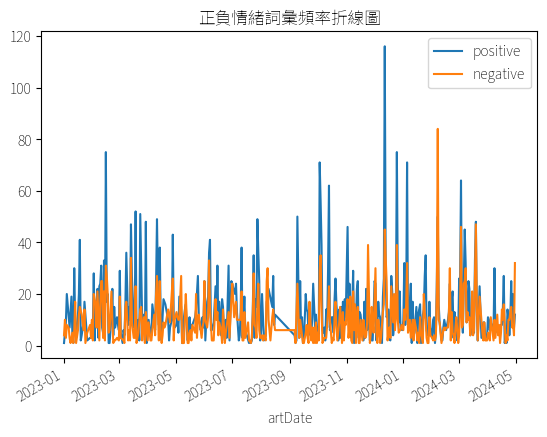

In [15]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖")  # 記得加上才能顯示中文
plt.show()

```Moving average```
- rolling average（滾動平均）是一種將時間序列數據平滑化的技術，有助於去除數據中的噪聲，使趨勢更加明顯，同時仍然保留一定的時間特徵。
- 在情緒分析中，特別是當你有一系列時間序列的情緒數據時，使用滾動平均有助於平滑數據，使情緒趨勢更加清晰。
    1. **去除瞬間噪聲**： 情緒數據可能受到瞬間事件或噪聲的影響，例如突發的大量評論或新聞。滾動平均有助於平滑這些突變，使你更容易觀察到整體趨勢。
    2. **強調長期趨勢**： 滾動平均有助於強調長期情緒趨勢，而不受短期波動的干擾。這對於觀察情緒的漸變和長期變化非常有用。


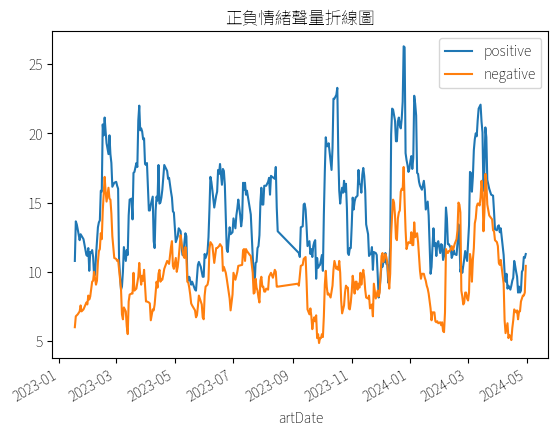

In [16]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒聲量折線圖")  # 記得加上才能顯示中文
plt.show()

畫出每天的情緒總分數，可以看到正面的詞出現頻率幾乎每天都超過負面，是個氣氛和諧的討論版。

```詞頻缺點```

如果某一天有什麼事件發生而導致正負向詞頻數隨之飆高，在趨勢圖看來可能會認為該區間的正負向情緒較為顯著，但也有可能是因為總體情緒詞彙本來就比較多而導致的。

以比例的方式來看，我們可以觀察到某個情緒詞在總體情緒詞彙中所佔的比例，就算某一天文章數相較多，也不會影響到比例的呈現。

### 3.4 正負向情緒詞彙比例折線圖圖

```lambda```函式是一種匿名函式，包含以下幾點特性：

+ 不需要定義函式名稱
+ 只能有一行運算式
+ 執行完後會自動回傳結果，不需要return   

因此```lambda```適合在該函式只有單行運算式且不會被重複呼叫時使用

參考網址：   
[Python Lambda](https://www.w3schools.com/python/python_lambda.asp)   
[Lambda — Python 重要語法技巧](https://medium.com/johnliu-的軟體工程思維/lambda-python-重要語法技巧-27c467ddfa16)

In [17]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

,artDate,sentiments,size,ratio
3,2023-01-01,negative,4,0.800000
4,2023-01-01,positive,1,0.200000
7,2023-01-02,negative,10,0.666667
8,2023-01-02,positive,5,0.333333
11,2023-01-03,negative,3,0.250000
...,...,...,...,...
1989,2024-04-28,positive,20,0.714286
1993,2024-04-29,negative,4,0.363636
1994,2024-04-29,positive,7,0.636364
1998,2024-04-30,negative,32,0.727273


In [18]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

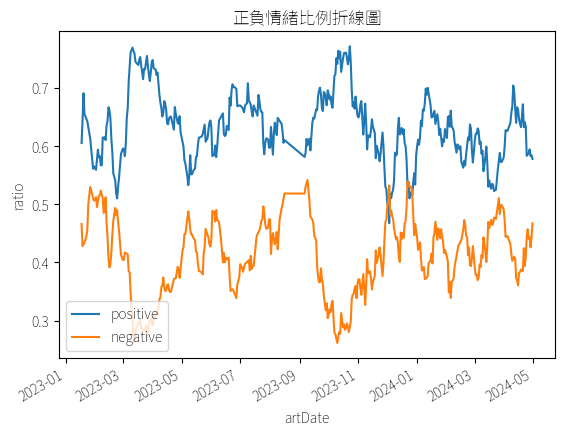

In [19]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖")

### 3.5 正負向情緒分數折線圖

In [20]:
sentiment_count

,artDate,sentiments,size,ratio
3,2023-01-01,negative,4,0.800000
4,2023-01-01,positive,1,0.200000
7,2023-01-02,negative,10,0.666667
8,2023-01-02,positive,5,0.333333
11,2023-01-03,negative,3,0.250000
...,...,...,...,...
1989,2024-04-28,positive,20,0.714286
1993,2024-04-29,negative,4,0.363636
1994,2024-04-29,positive,7,0.636364
1998,2024-04-30,negative,32,0.727273


In [21]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

,artDate,negative,positive
0,2023-01-01,4.0,1.0
1,2023-01-02,10.0,5.0
2,2023-01-03,3.0,9.0
3,2023-01-04,8.0,20.0
4,2023-01-06,7.0,11.0


In [22]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

,artDate,negative,positive,sentiment_value
0,2023-01-01,4.0,1.0,-3.0
1,2023-01-02,10.0,5.0,-5.0
2,2023-01-03,3.0,9.0,6.0
3,2023-01-04,8.0,20.0,12.0
4,2023-01-06,7.0,11.0,4.0


Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

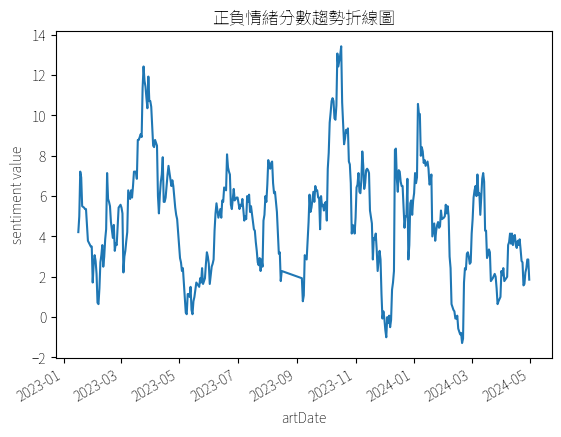

In [24]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖")

### 3.6 文章為單位的情緒分析

In [25]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article

,artUrl,sentiments,size
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,affect,2
1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,negative,1
2,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,positive,1
3,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,affect,3
4,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,anger,1
...,...,...,...
4833,https://www.ptt.cc/bbs/car/M.1714470321.A.C60....,positive,3
4834,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,affect,4
4835,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,positive,4
4836,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,affect,1


In [26]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2.0,0.0,0.0,1.0,1.0,0.0
1,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,3.0,1.0,1.0,3.0,0.0,0.0
2,https://www.ptt.cc/bbs/car/M.1672634853.A.527....,14.0,1.0,0.0,9.0,5.0,0.0
3,https://www.ptt.cc/bbs/car/M.1672653666.A.3F2....,1.0,0.0,0.0,0.0,0.0,0.0
4,https://www.ptt.cc/bbs/car/M.1672658487.A.A66....,1.0,0.0,0.0,1.0,0.0,0.0


In [27]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2.0,0.0,0.0,1.0,1.0,0.0,0.0
1,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,3.0,1.0,1.0,3.0,0.0,0.0,-3.0
2,https://www.ptt.cc/bbs/car/M.1672634853.A.527....,14.0,1.0,0.0,9.0,5.0,0.0,-4.0
3,https://www.ptt.cc/bbs/car/M.1672653666.A.3F2....,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,https://www.ptt.cc/bbs/car/M.1672658487.A.A66....,1.0,0.0,0.0,1.0,0.0,0.0,-1.0


In [28]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value,sentiment_class
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2.0,0.0,0.0,1.0,1.0,0.0,0.0,負向
1,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,3.0,1.0,1.0,3.0,0.0,0.0,-3.0,負向
2,https://www.ptt.cc/bbs/car/M.1672634853.A.527....,14.0,1.0,0.0,9.0,5.0,0.0,-4.0,負向
3,https://www.ptt.cc/bbs/car/M.1672653666.A.3F2....,1.0,0.0,0.0,0.0,0.0,0.0,0.0,負向
4,https://www.ptt.cc/bbs/car/M.1672658487.A.A66....,1.0,0.0,0.0,1.0,0.0,0.0,-1.0,負向
...,...,...,...,...,...,...,...,...,...
1388,https://www.ptt.cc/bbs/car/M.1714444417.A.274....,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向
1389,https://www.ptt.cc/bbs/car/M.1714451073.A.EE8....,2.0,0.0,0.0,1.0,1.0,0.0,0.0,負向
1390,https://www.ptt.cc/bbs/car/M.1714470321.A.C60....,17.0,3.0,1.0,28.0,3.0,0.0,-25.0,負向
1391,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,4.0,0.0,0.0,0.0,4.0,0.0,4.0,正向


In [29]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date
clear_df_sentiment

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentiment_class
0,1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,xross,car,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""maniaque"", ""...",99.36.164.58,2023-01-02 01:04:34,ptt,負向
1,2,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,jpopo0543,car,各位前輩好\r\n 想買中古特斯拉\r\n里程約5萬上下的\r\n\r\n擔心電池久了會掉電...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""r7698"", ""cmt...",114.46.142.179,2023-01-02 01:04:40,ptt,負向
2,3,https://www.ptt.cc/bbs/car/M.1672634853.A.527....,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,2023-01-02,weiflower520,car,原文連結：\r\nhttps://star.setn.com/news/1232578?ut...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""tyrande"", ""c...",27.247.164.57,2023-01-03 01:04:36,ptt,負向
3,4,https://www.ptt.cc/bbs/car/M.1672653666.A.3F2....,[討論]是不是真的有些四輪覺得自己是大爺？,2023-01-02,torrest,car,如題 本身開特斯拉\r\n\r\n最近出門覺得找車位很煩都騎家裡超舊機車\r\n\r\n基本...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""kutkin"", ""cm...",27.242.163.97,2023-01-03 01:04:36,ptt,負向
4,5,https://www.ptt.cc/bbs/car/M.1672658487.A.A66....,[新聞]2022美國汽車召回排名揭曉第一名超過8,2023-01-02,SakuraHana,car,原文連結：\r\nhttps://auto.ltn.com.tw/news/21866/3\...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""luke2007"", ""...",220.129.145.135,2023-01-03 01:04:36,ptt,負向
...,...,...,...,...,...,...,...,...,...,...,...,...
1581,1582,https://www.ptt.cc/bbs/car/M.1714444417.A.274....,Re:[新聞]特斯拉「全新入門電動車」準備量產！80,2024-04-30,QuentinHu,car,哪有到1.5倍，1.5那種是油車\r\n電動車現在沒有貨物稅\r\nhttps://i.im...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""sted0101"", ""...",175.98.154.254,2024-05-01 01:05:53,ptt,正向
1582,1583,https://www.ptt.cc/bbs/car/M.1714451073.A.EE8....,Re:[分享]TucsonL撞緩撞車啦,2024-04-30,H2,car,要系統性的改善緩撞車被ACC\r\n撞的問題！\r\n\r\n建議交通部學習美國跟特斯拉的案...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""ilovedirk41""...",61.66.151.73,2024-05-01 01:05:53,ptt,負向
1583,1584,https://www.ptt.cc/bbs/car/M.1714470321.A.C60....,Re:[新聞]銷售降溫賓士上季獲利銳減逾三成、福斯,2024-04-30,orzzz,car,****:都轉單到特斯拉了 誰跟你買雙B\r\n(不針對ID，本板及M01有多位朋友同想法)...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""sted0101"", ""...",1.200.2.37,2024-05-01 01:05:57,ptt,負向
1584,1585,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,David989,car,最近物色下一台車\r\n\r\n原本抓250左右\r\n\r\n上週去看了特斯拉 MODEL...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""birdane32"", ...",218.161.8.52,2024-05-01 01:05:57,ptt,正向


In [30]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

,artDate,sentiment_class,size
0,2023-01-01,負向,2
1,2023-01-02,負向,3
2,2023-01-03,正向,1
3,2023-01-03,負向,1
4,2023-01-04,正向,2
...,...,...,...
648,2024-04-28,正向,2
649,2024-04-29,正向,2
650,2024-04-29,負向,1
651,2024-04-30,正向,4


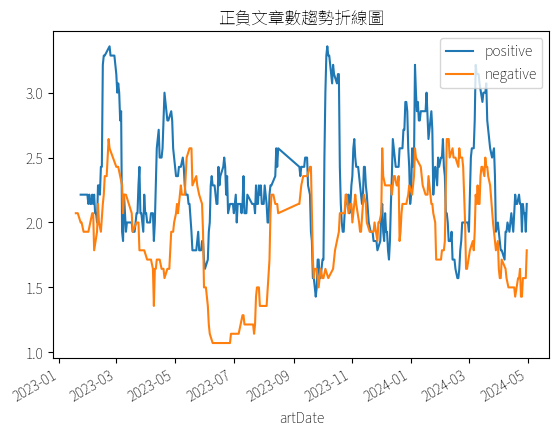

In [31]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖")  # 記得加上才能顯示中文
plt.show()

某些時間段落 相差甚大，或 負面高於正面 

### 3.7 情緒代表字

In [32]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

,word,sentiments,size
557,安全,positive,271
556,安全,affect,271
253,分享,affect,191
254,分享,positive,191
1763,遇到,affect,184
...,...,...,...
981,操心,negative,1
1494,糟蹋,affect,1
1495,糟蹋,anger,1
1496,糟蹋,negative,1


In [33]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

,word,sentiments,size
557,安全,positive,271
254,分享,positive,191
408,喜歡,positive,182
625,希望,positive,156
1075,朋友,positive,148
66,不錯,positive,145
1477,簡單,positive,122
583,容易,positive,118
1704,豪華,positive,113
1636,解決,positive,99


In [34]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

,word,sentiments,size
86,事故,negative,137
1831,降低,negative,125
1529,缺點,negative,112
1632,衰退,negative,110
463,壓力,negative,108
949,控制,negative,101
437,嚴重,negative,82
984,擔心,negative,76
1621,虧損,negative,70
340,受傷,negative,62


C:\Users\hands\AppData\Local\Temp\ipykernel_11164\2349181045.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"])
C:\Users\hands\AppData\Local\Temp\ipykernel_11164\2349181045.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

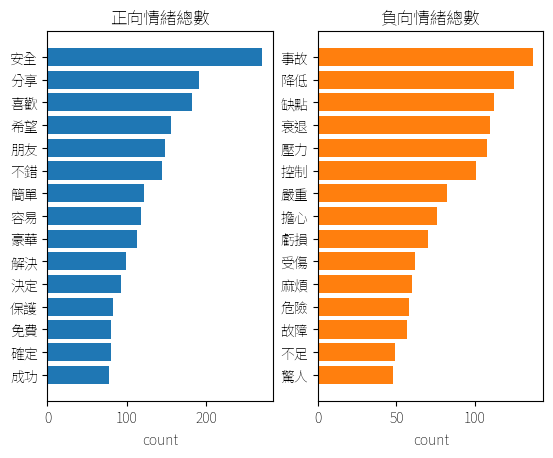

In [35]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

#### 檢查情緒詞是否符合本文本

In [40]:
filtered_df = sent_df[sent_df['sentence'].str.contains('控制', na=False)]
filtered_df.head()

,artUrl,artTitle,artDate,artContent,sentence
3408,https://www.ptt.cc/bbs/car/M.1676269915.A.41E....,[新聞]特斯拉賣一輛車的獲利是豐田5倍股價較年,2023-02-13,原文連結：\r\nhttps://udn.com/news/story/6811/69625...,\r\r心得說明字以上\r有這麼大的獲利當然就有空間可以玩大漲與大跌的定價策略\r而且消費者...
4090,https://www.ptt.cc/bbs/car/M.1676623286.A.8E6....,[新聞]曾被認為可挑戰特斯拉的Rivian改變戰略,2023-02-17,曾被認為可挑戰特斯拉的Rivian，改變戰略，往電動自行車市場前進\r\n\r\n原文連結：...,成本控制也成為Rivian經營的缺點
4383,https://www.ptt.cc/bbs/car/M.1677076934.A.A5C....,Re:[心得]特斯拉好在哪？,2023-02-22,1.最重要的功能就是裝逼。\r\n其實我車子是貸款7年的。還有100萬還沒繳\r\n\r\n...,逼逼叫超大聲\r\r趕快彎腰起來控制方向盤
4386,https://www.ptt.cc/bbs/car/M.1677076934.A.A5C....,Re:[心得]特斯拉好在哪？,2023-02-22,1.最重要的功能就是裝逼。\r\n其實我車子是貸款7年的。還有100萬還沒繳\r\n\r\n...,總算控制住\r\r我懷疑林志穎也幹過相同的事\r\r後來發現我後面的車本來距離我個車身\r控...
5738,https://www.ptt.cc/bbs/car/M.1678804708.A.7EA....,[新聞]特斯拉新店追撞前車駕駛父暴走遷怒,2023-03-14,原文連結：\r\nhttps://ynews.page.link/PyTkv\r\n原文內容...,圖翻攝畫面\r\r心得說明\r影片\r\r特斯拉駕駛自己撞前面的車子\r關女兒什麼事\r情緒...


In [41]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

豐田已經是有名的成本控制專家了玩大漲與大跌的定價策略
成本控制也成為Rivian經營的缺點
趕快彎腰起來控制方向盤
控制好方向盤後的車本來距離我個車身
這樣還想開車出門前面的車子
並接管儀表板以及對座椅加熱和空調等功能進行控制
也算某種置入性行銷音控制車上副駕冷氣大小起有違常理T
考慮換個大一點的車子
沒有人控制
所以不確定如果讓EAP繼續控制最後是會怎樣
   如果臨時要開家人的油車車子
態穩定TCL 循跡防滑控制等系統急煞車警示RAB 預警煞車BOS 煞車優先ASC 車身動
可為後排乘客提供更多娛樂和控制選項
以及三區域溫度控制
特斯拉評估還是要控制在KMh以下才有機會開到
開到楠梓左右提示就變成要控制在KMh才可以到
福特還是得降價含淚銷售流所以就算虧錢牌了河
以取得在漢堡港的物流中心控制權
特斯拉特有的單踏板模式 可讓駕駛人僅靠一個踏板控制車輛的加速或停車
重量還輕了量 vs  大了續航力能耗跟重量控制作比較好
只有自己駕駛過才會知道喜不喜歡適不適合其是在中南部的用九成 夠我兩三個禮拜使用視訊會議個人
也就是說人坐上去控制
雖然能避免就避免分神的人來說幫助非常大程度
特斯拉的APP可說是又將車主對車輛的控制權結合時下的智慧型手機使用者的習慣
車門鎖啟閉的功能無刻在世界的任何角落對你的車輛
 溫度控制選項開關冷氣
利用哨兵模式觀看現場即時影像的畫面
工廠普遍都在控制加班
都在透過控制加班關停部分產線來調整生產節奏
道居中主動式車距控制巡航adaptive cruise control
故障係因與集成充電控制單元 ICCU 有關
駕駛體驗和氣候進行調查能控制和顯示外觀駕駛輔助內飾動力總成座椅
其中更多的操作和功能都由軟體控制
連網的一切擎到影音系統再到可以將汽車與行動應用程式
其從行駛路上衝向路邊
一個法國駭客團隊在不到兩分鐘的時間內透過藍牙控制了一輛特斯拉
快發生loitte認為電網關閉或汽車大規模控制不會很
製造商和政府必須更好地控制這種環境中可能發生的事情
OTA就是個智障次高爾夫到現在還是搞不懂大眾那個傳統圓盤控制燈光的使用方式
我就很想問年輕人動駕駛時請保持握住方向盤盯著道路以防需要緊急切換人工控制
道居中主動式車距控制巡航adaptive cruise control
有自動緊急剎車自適應巡航控制碰撞警告和 度可視性等功能
有自動緊急剎車自適應巡航控

#### 重新計算情緒

控制、驚人、不足、隨便、警告

In [42]:
# 設定要移除的字詞列表
words_to_remove = [ '控制', '驚人', '不足', '隨便', '警告']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict_revise,
                              how="left")
ptt_liwc_df_revise.head()

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,八卦,affect
1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,八卦,negative
2,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,官網,NaN
3,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,二手車,NaN
4,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,三方,NaN


C:\Users\hands\AppData\Local\Temp\ipykernel_11164\1871799801.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"])
C:\Users\hands\AppData\Local\Temp\ipykernel_11164\1871799801.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

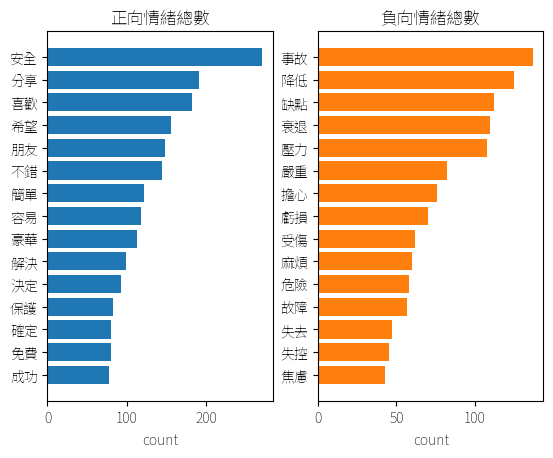

In [43]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

重新繪製情緒分數趨勢圖

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

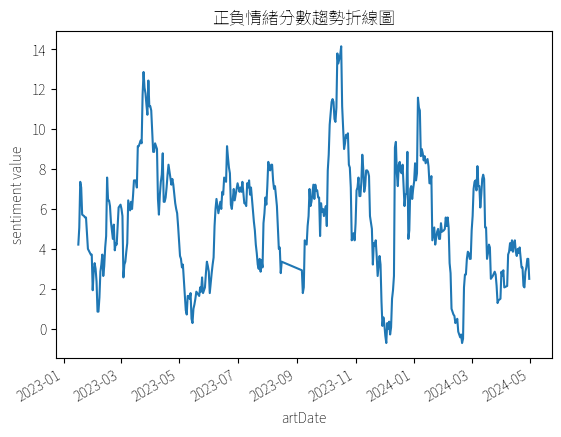

In [44]:
sentiment_count_revise = pd.DataFrame(
    ptt_liwc_df_revise.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative") 
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["artDate"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value_revise["artDate"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖")

### 3.8 文字雲
如果文字雲中的字詞大小越大，代表出現頻率越高

#### 2023-10-15 ~2023-11-01 文字雲
2023-10-15 ~2023-11-01 在情緒分數趨勢圖上顯示比較低的分數，我們用文字雲來看一下這段時間出現了什麼關鍵字

將前面計算出的文章情緒類別合併，以利我們過濾出負面文章資料

In [45]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
ptt_liwc_df_revise.head()

,artUrl,artDate,artTitle,artContent,word,sentiments,sentiment_class
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,八卦,affect,負向
1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,八卦,negative,負向
2,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,官網,NaN,負向
3,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,二手車,NaN,負向
4,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,2023-01-01,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,三方,NaN,負向


In [46]:
sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
sent_df.head()

,artUrl,artTitle,artDate,artContent,sentence,sentiment_class
0,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\r\n\r\n比很多第三方平台都便宜\r\nhttps://www....,八卦是官網特斯拉二手車\r\r比很多第三方平台都便宜\r\r等等黨會勝利嗎,負向
1,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\r\n 想買中古特斯拉\r\n里程約5萬上下的\r\n\r\n擔心電池久了會掉電...,各位前輩好\r 想買中古特斯拉\r里程約萬上下的\r\r擔心電池久了會掉電\r越充越少電 里...,負向
2,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\r\n 想買中古特斯拉\r\n里程約5萬上下的\r\n\r\n擔心電池久了會掉電...,\r還是建議買中古開即可,負向
3,https://www.ptt.cc/bbs/car/M.1672634853.A.527....,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,2023-01-02,原文連結：\r\nhttps://star.setn.com/news/1232578?ut...,原文連結\r\rinpagefbclidIwARouxXHXAJRTNgQmBWTEtyED...,負向
4,https://www.ptt.cc/bbs/car/M.1672634853.A.527....,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,2023-01-02,原文連結：\r\nhttps://star.setn.com/news/1232578?ut...,雖然用自動駕駛,負向


In [47]:
date = "2023-10-15"
end_date = "2023-11-01"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask]
ptt_df_wc

,artUrl,artDate,artTitle,artContent,word,sentiments,sentiment_class
117608,https://www.ptt.cc/bbs/car/M.1697602381.A.2B1....,2023-10-18,Re:[新聞]特斯拉電池遭雨水浸泡！ 「維修費70萬,https://www.mobile01.com/topicdetail.php?f=346...,好奇,NaN,負向
117609,https://www.ptt.cc/bbs/car/M.1697602381.A.2B1....,2023-10-18,Re:[新聞]特斯拉電池遭雨水浸泡！ 「維修費70萬,https://www.mobile01.com/topicdetail.php?f=346...,油車,NaN,負向
117610,https://www.ptt.cc/bbs/car/M.1697602381.A.2B1....,2023-10-18,Re:[新聞]特斯拉電池遭雨水浸泡！ 「維修費70萬,https://www.mobile01.com/topicdetail.php?f=346...,泡水修,NaN,負向
117611,https://www.ptt.cc/bbs/car/M.1697602381.A.2B1....,2023-10-18,Re:[新聞]特斯拉電池遭雨水浸泡！ 「維修費70萬,https://www.mobile01.com/topicdetail.php?f=346...,google,NaN,負向
117612,https://www.ptt.cc/bbs/car/M.1697602381.A.2B1....,2023-10-18,Re:[新聞]特斯拉電池遭雨水浸泡！ 「維修費70萬,https://www.mobile01.com/topicdetail.php?f=346...,一下,NaN,負向
...,...,...,...,...,...,...,...
125185,https://www.ptt.cc/bbs/car/M.1698829693.A.DBF....,2023-11-01,Re:[新聞]特斯拉失控狂飆時速198公里失事致2死3傷,中國法院判決，特斯拉潮州車禍與車輛本身無關\r\n財訊快報\r\n2023年11月1日 週三...,可憐,affect,負向
125186,https://www.ptt.cc/bbs/car/M.1698829693.A.DBF....,2023-11-01,Re:[新聞]特斯拉失控狂飆時速198公里失事致2死3傷,中國法院判決，特斯拉潮州車禍與車輛本身無關\r\n財訊快報\r\n2023年11月1日 週三...,可憐,negative,負向
125187,https://www.ptt.cc/bbs/car/M.1698829693.A.DBF....,2023-11-01,Re:[新聞]特斯拉失控狂飆時速198公里失事致2死3傷,中國法院判決，特斯拉潮州車禍與車輛本身無關\r\n財訊快報\r\n2023年11月1日 週三...,可憐,sad,負向
125188,https://www.ptt.cc/bbs/car/M.1698829693.A.DBF....,2023-11-01,Re:[新聞]特斯拉失控狂飆時速198公里失事致2死3傷,中國法院判決，特斯拉潮州車禍與車輛本身無關\r\n財訊快報\r\n2023年11月1日 週三...,車板,NaN,負向


In [48]:
date = "2023-10-15"
end_date = "2023-11-01"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

,word,size
1036,電動車,32
1064,駕駛,17
919,車主,16
219,充電,14
73,iPhone,14
...,...,...
491,愛車,1
492,感到,1
493,感覺,1
494,態度,1


(-0.5, 399.5, 199.5, -0.5)

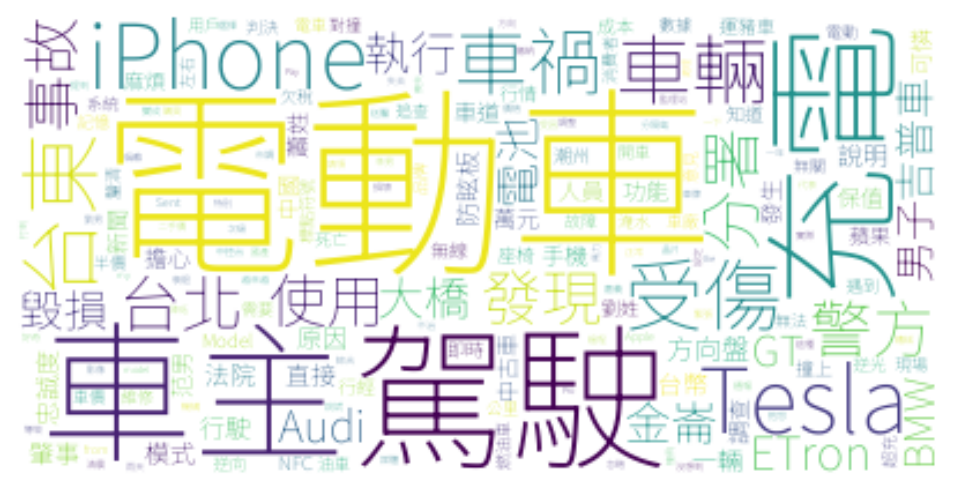

In [49]:
# wordcloud 的 input 是 dictionary
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

關鍵字出現了「iphone」、「特斯拉」、「賣超」、「衝突」、「下跌」的關鍵字，可能是在說明特斯拉充電疑慮。

In [107]:
date = "2023-01-10"
end_date = "2023-05-31"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & ( # 時間區間
    ptt_liwc_df_revise['sentiment_class'] == "負向")  & ( # 負面文章
    ptt_liwc_df_revise['artContent'].str.contains('美債')) & ( # 內文包含美債
    ptt_liwc_df_revise["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

ValueError: We need at least 1 word to plot a word cloud, got 0.

利用「下挫」去查看原文內容

In [ ]:
date = "2023-10-15"
end_date = "2023-11-01"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "負向") & (
    sent_df['artContent'].str.contains('美債')) & (
    sent_df['sentence'].str.contains('下挫')) # 包含「下挫」的句子

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df

,artUrl,artTitle,artDate,artContent,sentence,sentiment_class
44922,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,引發投資人擔憂聯準會Fed可能將利率維持在高檔更久,負向
44923,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,並可能再度升息,負向
44924,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,\r同\r時,負向
44925,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,\r道瓊工業指數早盤跌近百點或,負向
44926,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,標普指數和那斯達克綜合指數各跌和,負向
44927,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,\r費城半導體指數下挫,負向
44928,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,台積電ADR也跌,負向
44929,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,\r\r美國月整體零售銷售月增,負向
44930,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,遠高於預估的增幅,負向
44931,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,扣除汽車之後的核心銷售額比\r月增加,負向


文章中提到了台股重挫，道瓊指數下跌